## Importando Bibliotecas

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
import warnings
import sys
sys.path.append(r'/home/jean/projetos/pod-bank/global/')
from util import *
warnings.filterwarnings("ignore")
random.seed(42)

/home/jean/projetos/pod-bank/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lendo os dados

In [2]:
df_treino_full = pd.read_parquet('../data/abt/abt_train', engine='fastparquet')

In [3]:
df_treino_full.shape

(215257, 552)

### Aplicando primeira feature selection

In [4]:
import pickle
with open('../artifacts/prd_first_list_features.pkl', 'rb') as f:
    colunas_finais = pickle.load(f)

In [5]:
df_treino_full = df_treino_full[colunas_finais]
df_treino_full.shape

(215257, 161)

## Split dos dados

In [6]:

from sklearn.model_selection import train_test_split


abt = df_treino_full.drop(columns=['TARGET','SK_ID_CURR'])
target = df_treino_full.TARGET

X_train, X_test, y_train, y_test = train_test_split(abt,target,test_size=0.3,random_state=0)



## Dataprep

In [7]:
import numpy as np
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

abt_treino = pd.concat((X_train,y_train),axis=1)
abt_test = pd.concat((X_test,y_test),axis=1)

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

num_features_train = X_train.select_dtypes(exclude='object')
cat_features_train = X_train.select_dtypes(include='object')

num_features_test = X_test[num_features_train.columns]
cat_features_test = X_test[cat_features_train.columns]

lista_nums = num_features_train.columns
lista_cats = cat_features_train.columns

df1 = pd.DataFrame(imputer_num.fit_transform(num_features_train),columns=lista_nums)
df2 = pd.DataFrame(imputer_num.transform(num_features_test),columns=lista_nums)
df1.index = num_features_train.index
df2.index = num_features_test.index
num_features_train = df1.copy()
num_features_test = df2.copy()

df1 = pd.DataFrame(imputer_cat.fit_transform(cat_features_train),columns=lista_cats)
df2 = pd.DataFrame(imputer_cat.transform(cat_features_test),columns=lista_cats)
df1.index = cat_features_train.index
df2.index = cat_features_test.index
cat_features_train = df1.copy()
cat_features_test = df2.copy()

ce = TargetEncoder()

cat_features_train = ce.fit_transform(cat_features_train,y_train)
cat_features_test = ce.transform(cat_features_test,y_test)

new_abt_treino = pd.concat((num_features_train,cat_features_train),axis=1)
new_abt_teste = pd.concat((num_features_test,cat_features_test),axis=1)

threshold = 0.5

# Calculate the correlation matrix
corr_matrix = new_abt_treino.corr().abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop based on the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the columns
new_abt_treino = new_abt_treino.drop(columns=to_drop)
new_abt_teste = new_abt_teste.drop(columns=to_drop)

rf_model = RandomForestClassifier(
    random_state=0,
    class_weight='balanced',       # Balanceamento automático de classes
    max_depth=10,                  # Limita a profundidade máxima de cada árvore a 10 níveis
    min_samples_split=20,          # Exige pelo menos 20 amostras para considerar uma divisão
    n_estimators=100               # Mantendo 100 árvores na floresta (parâmetro padrão)
)

rf_model.fit(new_abt_treino, y_train)

# Obtém importância das features do modelo treinado
feature_importance = rf_model.feature_importances_

df = pd.DataFrame({'Feature':new_abt_treino.columns,'Importance':feature_importance})

features_rl = df.sort_values(by='Importance',ascending=False)[:20].Feature.to_list()

In [8]:
features_rl = features_rl + ['TARGET']
features_rl

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'OCCUPATION_TYPE',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'DAYS_LAST_PHONE_CHANGE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'NAME_EDUCATION_TYPE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'CODE_GENDER',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU',
 'REGION_POPULATION_RELATIVE',
 'QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU',
 'QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU',
 'OWN_CAR_AGE',
 'VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU',
 'QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU',
 'TARGET']

In [62]:
#salvar lista em um arquivo .pkl
with open('../artifacts/features_reg_log.pkl', 'wb') as f:pickle.dump(features_rl, f)

In [10]:
abt_treino_01 = abt_treino[features_rl]
abt_treino_01.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,OCCUPATION_TYPE,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_LAST_PHONE_CHANGE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,...,DAYS_ID_PUBLISH,DAYS_REGISTRATION,VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,REGION_POPULATION_RELATIVE,QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,OWN_CAR_AGE,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,TARGET
28668,0.440058,0.688661,0.229335,Laborers,-3821,450000.0,-1953.0,-791.0,Secondary / secondary special,-791.0,...,-3891,-2441.0,4080279.02,0.009334,559.0,-37.0,NaN,NaN,-37.0,0
35005,NaN,0.646244,0.403597,Core staff,-587,882000.0,-160.0,NaN,Higher education,NaN,...,-323,-4130.0,NaN,0.009657,NaN,NaN,NaN,NaN,NaN,0
105487,0.495666,0.595644,NaN,Sales staff,-741,180000.0,-404.0,-268.0,Secondary / secondary special,-268.0,...,-1253,-8149.0,104542.29,0.031329,26.0,-7.0,7.0,NaN,-7.0,0
84068,0.681706,0.646119,0.678269,Core staff,-1712,481500.0,-2092.0,-1096.0,Higher education,-1096.0,...,-2515,-4823.0,5894964.00,0.019689,5428.0,-12.0,8.0,0.0,-12.0,0
51787,0.591977,0.701218,0.709834,None,365243,90000.0,-1005.0,-1269.0,Secondary / secondary special,-1269.0,...,-4625,-908.0,768555.00,0.019689,972.0,-129.0,NaN,NaN,-8.0,0


In [11]:
abt_test_01 = abt_test[features_rl]
abt_test_01.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,OCCUPATION_TYPE,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_LAST_PHONE_CHANGE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,...,DAYS_ID_PUBLISH,DAYS_REGISTRATION,VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,REGION_POPULATION_RELATIVE,QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,OWN_CAR_AGE,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,TARGET
22198,0.703203,0.575481,NaN,Laborers,-2268,1206000.0,-1889.0,-2489.0,Secondary / secondary special,-2489.0,...,-2918,-3020.0,1588419.0,0.026392,NaN,NaN,10.0,NaN,NaN,0
133679,0.553165,0.516697,0.26864,Laborers,-1139,90000.0,-351.0,350.0,Secondary / secondary special,NaN,...,-1217,-19.0,NaN,0.028663,NaN,NaN,1.0,NaN,-14.0,0
106217,NaN,0.285131,NaN,Cooking staff,-2761,630000.0,-510.0,7033.0,Secondary / secondary special,NaN,...,-1344,-1198.0,NaN,0.026392,NaN,-24.0,NaN,NaN,-24.0,0
149637,0.773896,0.727543,NaN,Cleaning staff,-5127,292500.0,-1537.0,-2121.0,Secondary / secondary special,-2121.0,...,-2979,-7577.0,484321.5,0.006629,NaN,NaN,NaN,NaN,-16.0,0
131246,0.431192,0.564683,NaN,Managers,-3590,292500.0,-1571.0,-2495.0,Higher education,-2495.0,...,-1849,-295.0,414639.0,0.035792,NaN,NaN,9.0,NaN,-28.0,0


## Impute missing

In [63]:
abt_treino_02, means = fillna_numeric(abt_treino_01)

with open('../artifacts/prd_fillna_reg_log.pkl', 'wb') as f:
  pickle.dump(means, f)

In [64]:
with open('../artifacts/prd_fillna_reg_log.pkl', 'rb') as f:
  loaded_means = pickle.load(f)

In [14]:
abt_test_02 = fillna_num_prod(abt_test_01, loaded_means)
abt_test_02.shape

(64578, 21)

In [15]:
abt_treino_03, modes = fillna_categorical(abt_treino_02)

with open('../artifacts/prd_fillna_categorical_rl.pkl', 'wb') as f:
  pickle.dump(modes, f)

In [16]:
with open('../artifacts/prd_fillna_categorical_rl.pkl', 'rb') as f:
  loaded_modes = pickle.load(f)

In [17]:
abt_test_03 = fillna_catg_prod(abt_test_02, loaded_modes)
abt_test_03.shape

(64578, 21)

In [18]:
features_rl

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'OCCUPATION_TYPE',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'DAYS_LAST_PHONE_CHANGE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'NAME_EDUCATION_TYPE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'CODE_GENDER',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU',
 'REGION_POPULATION_RELATIVE',
 'QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU',
 'QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU',
 'OWN_CAR_AGE',
 'VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU',
 'QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU',
 'TARGET']

## Verificando linearidade com a Log Odds

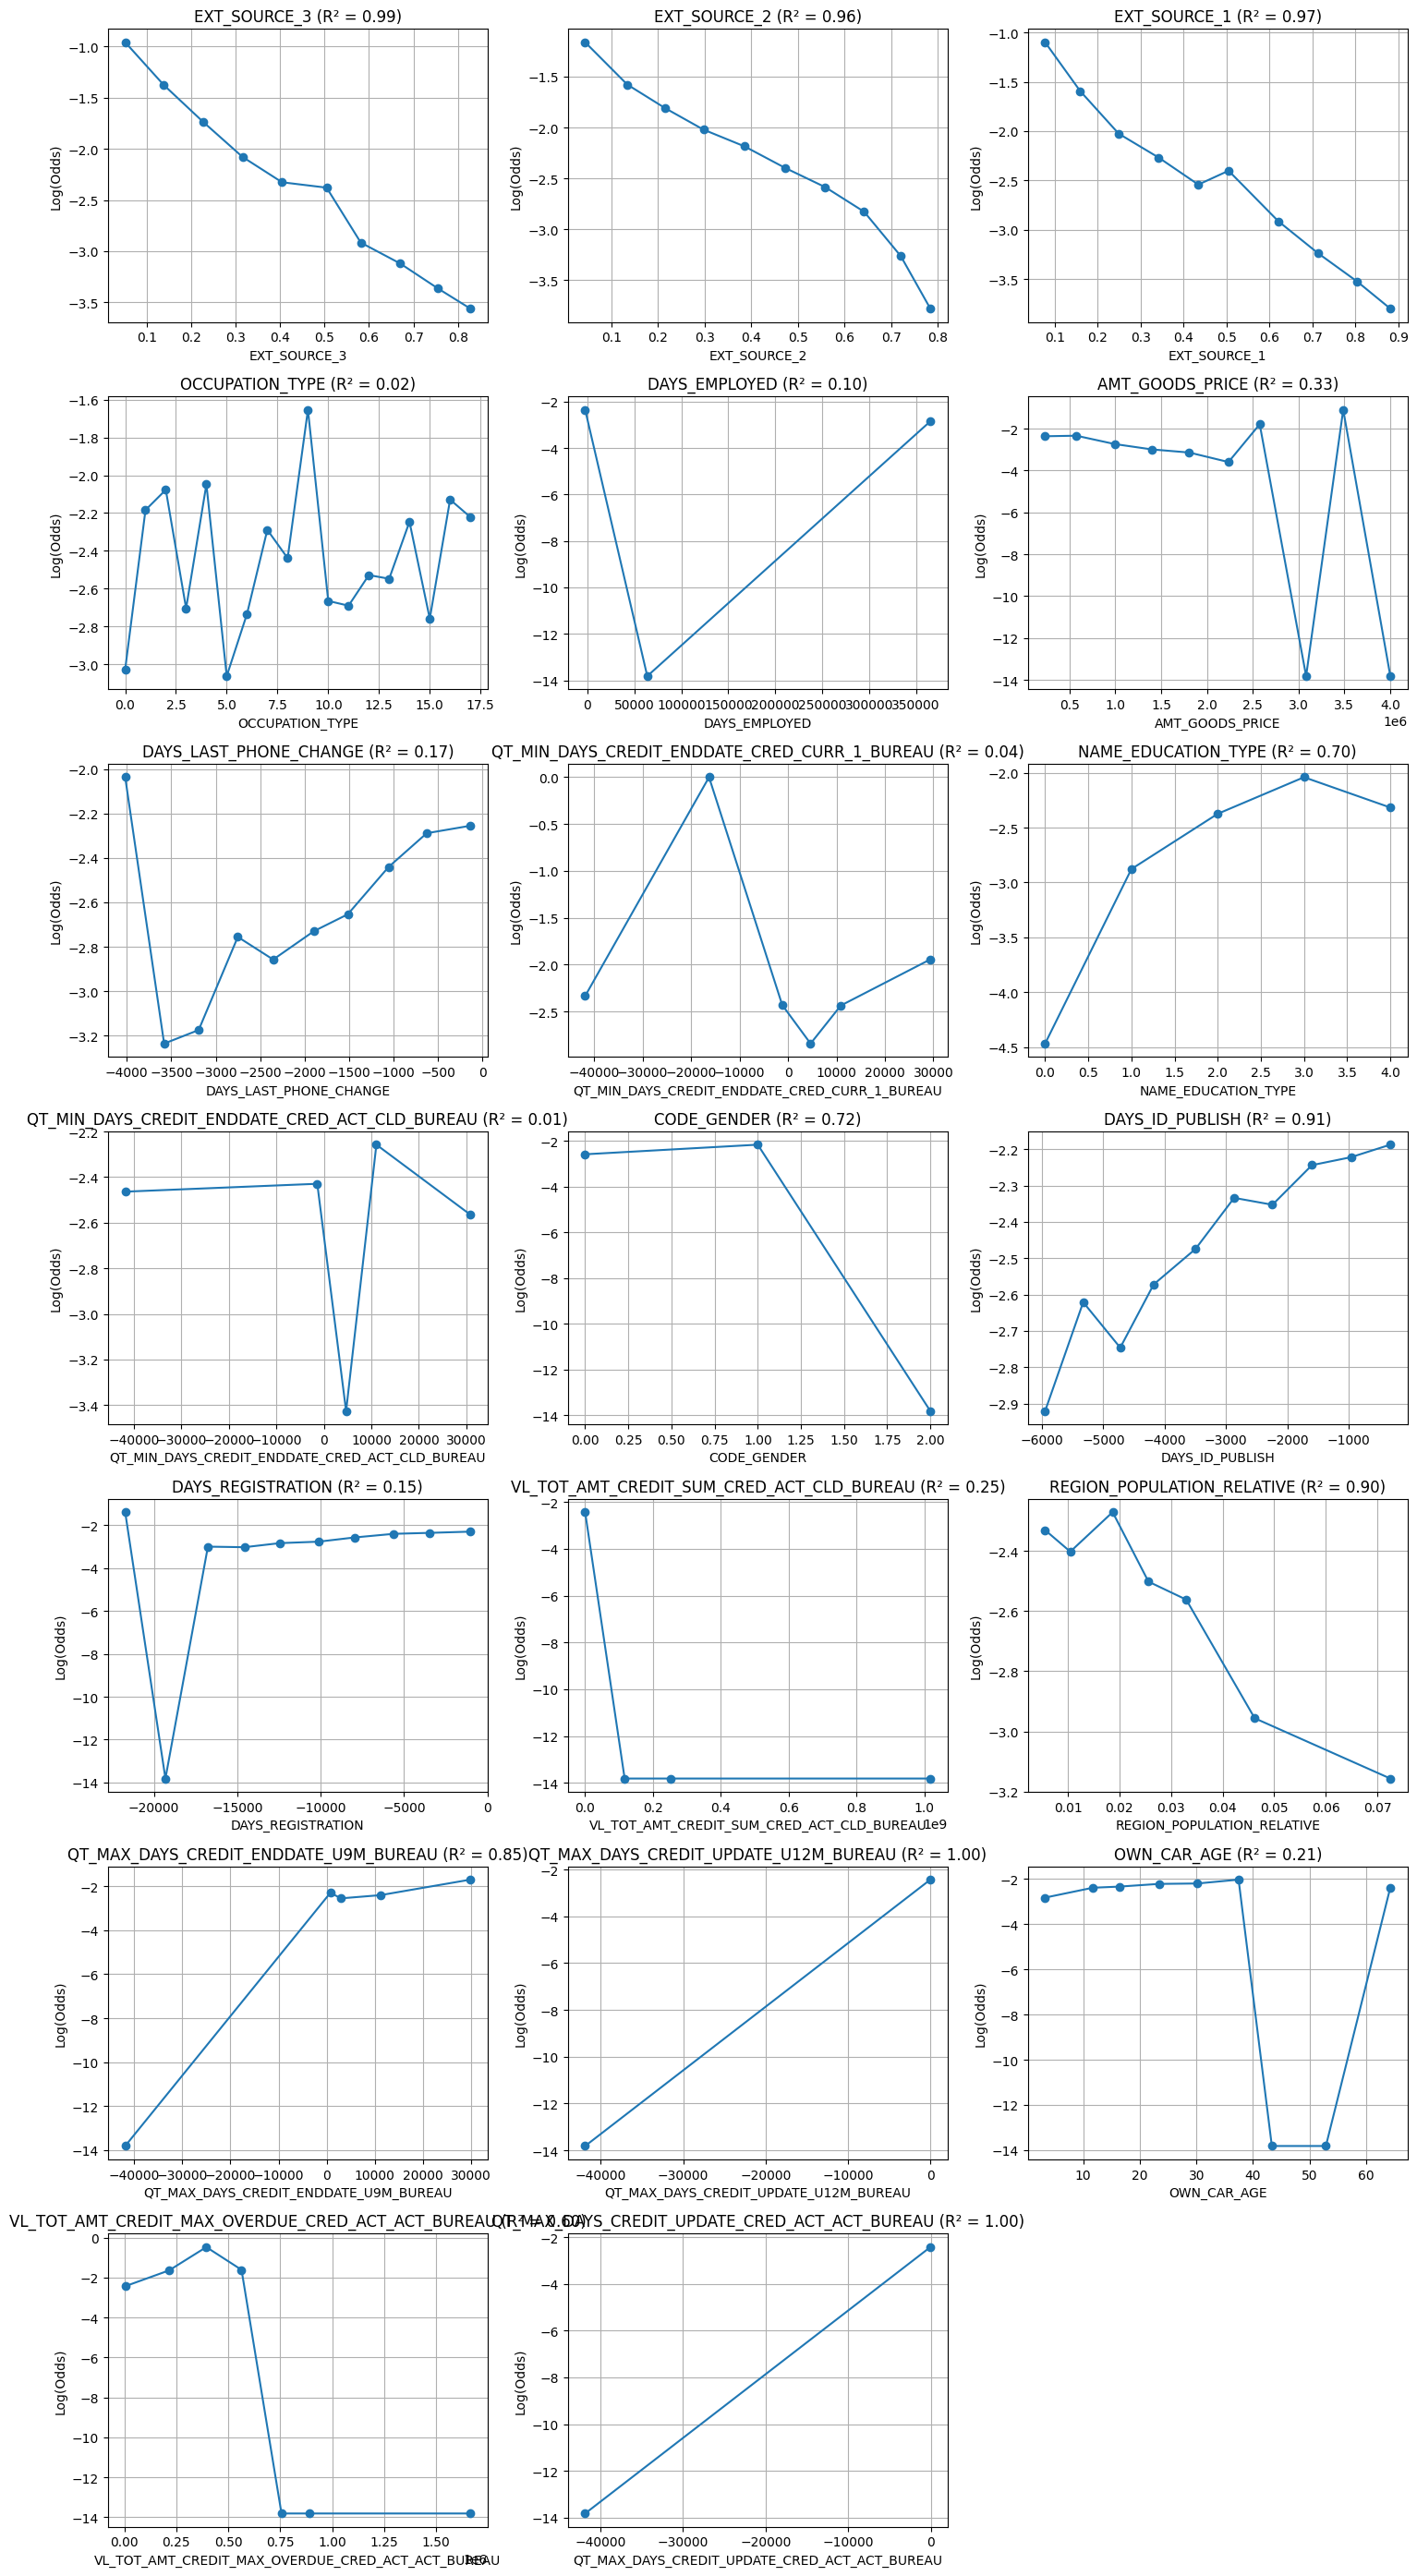

In [19]:
r2_df = calculate_r2_for_logodds_with_grid(
    abt_treino_03,
    list(abt_treino_03.drop(columns='TARGET').columns),
    target='TARGET',
    threshold=0.85,
    ncols=3
)

In [20]:
r2_df

,Variable,R^2,Feat Eng
0,EXT_SOURCE_3,0.985777,Usar como contínua
1,EXT_SOURCE_2,0.961862,Usar como contínua
2,EXT_SOURCE_1,0.973064,Usar como contínua
3,OCCUPATION_TYPE,0.021573,Categorizar
4,DAYS_EMPLOYED,0.096349,Categorizar
5,AMT_GOODS_PRICE,0.333214,Categorizar
6,DAYS_LAST_PHONE_CHANGE,0.171947,Categorizar
7,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,0.040392,Categorizar
8,NAME_EDUCATION_TYPE,0.698962,Categorizar
9,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,0.009743,Categorizar


In [21]:
variaveis_continuas = r2_df[r2_df['Feat Eng'] == 'Usar como contínua']['Variable'].tolist()
categorize_vars = r2_df[r2_df['Feat Eng'] == 'Categorizar']['Variable'].tolist()

## Categorização
## Categorizar as variáveis que estão não apresentaram comportamento linear com a log da odds

In [22]:
categorize_vars

['OCCUPATION_TYPE',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'DAYS_LAST_PHONE_CHANGE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'NAME_EDUCATION_TYPE',
 'QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'CODE_GENDER',
 'DAYS_REGISTRATION',
 'VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU',
 'OWN_CAR_AGE',
 'VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU']

In [23]:
# Verificar cardinalidade dessas variáveis
df =  generate_metadata_v2(abt_treino_03[categorize_vars])

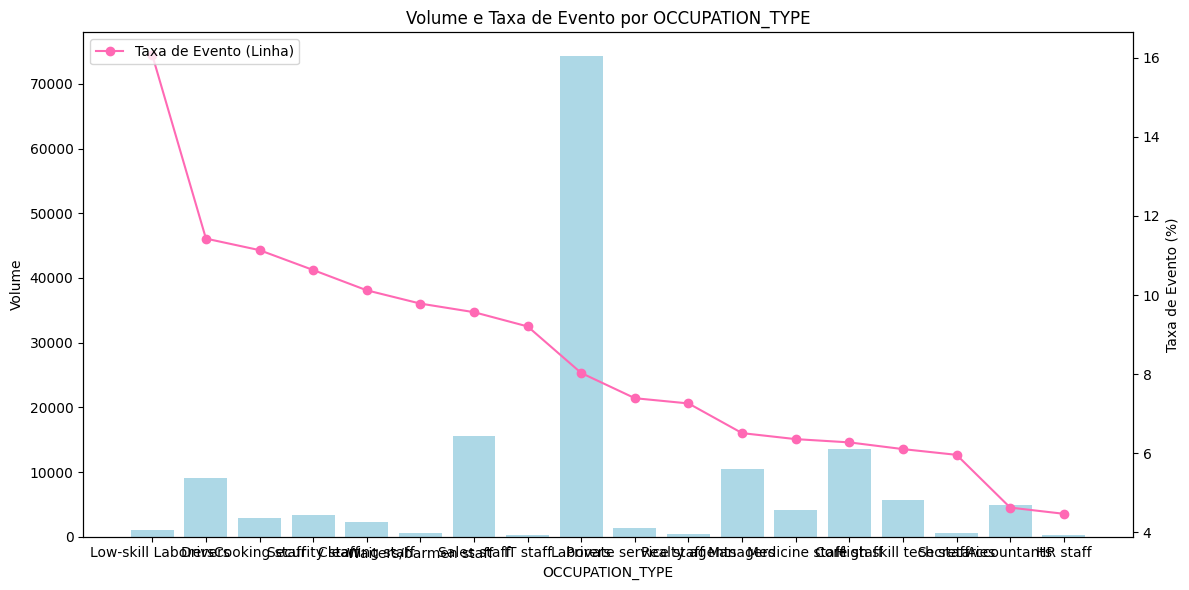

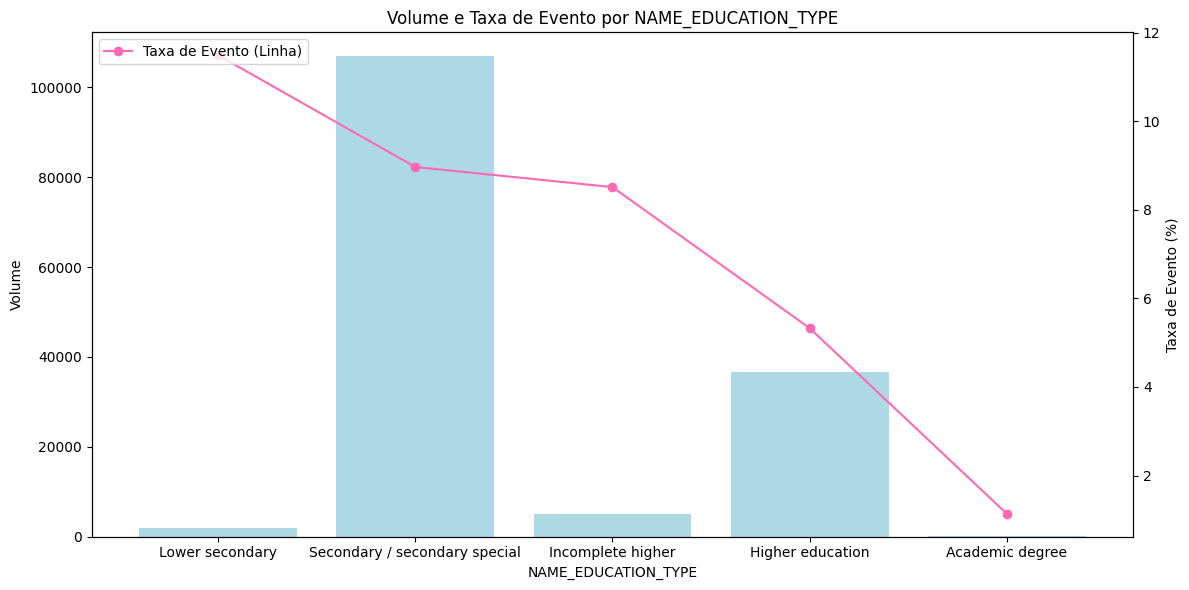

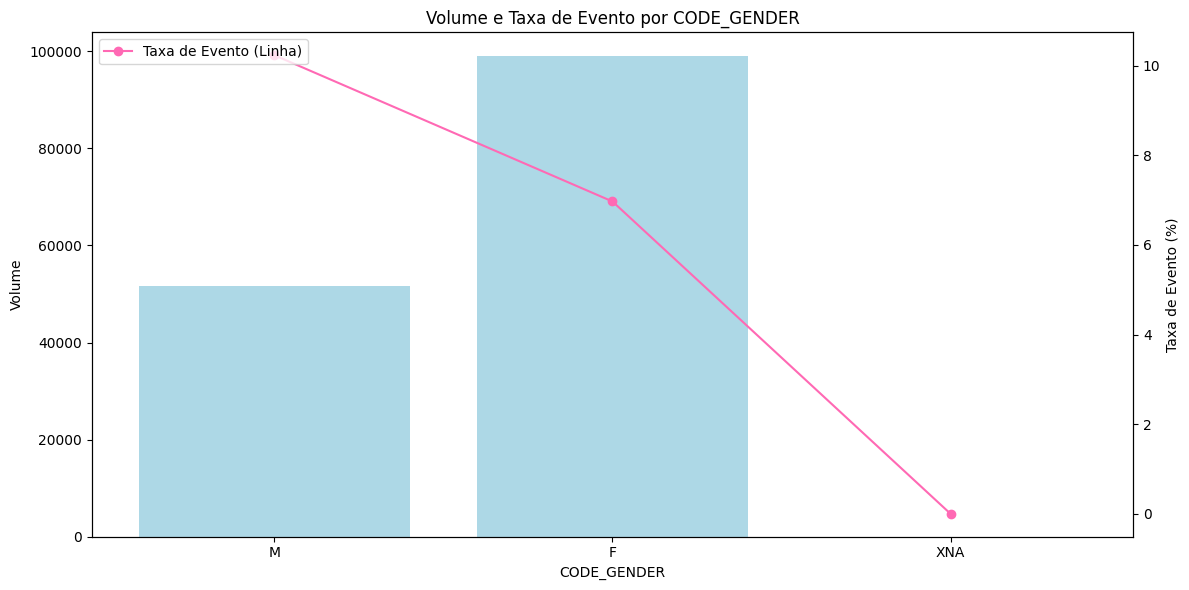

In [24]:
# Analizar essas variáveis (variaveis_categorizar) que contém baixa cardinalidade (menor ou igual a 20) e verificar se há ordenação entre as categorias
ordinais = df[df.cardinalidade <= 20].nome_variavel.to_list()
for var in ordinais:
    result = analyze_variable(abt_treino_03, var, "TARGET")

In [25]:
abt_treino_03.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,OCCUPATION_TYPE,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_LAST_PHONE_CHANGE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,...,DAYS_ID_PUBLISH,DAYS_REGISTRATION,VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,REGION_POPULATION_RELATIVE,QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,OWN_CAR_AGE,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,TARGET
28668,0.440058,0.688661,0.229335,Laborers,-3821.0,450000.0,-1953.0,-791.000000,Secondary / secondary special,-791.000000,...,-3891.0,-2441.0,4.080279e+06,0.009334,559.000000,-37.000000,12.065532,4160.509781,-37.00000,0
35005,0.511483,0.646244,0.403597,Core staff,-587.0,882000.0,-160.0,-1031.528897,Higher education,-1356.180463,...,-323.0,-4130.0,9.913785e+05,0.009657,2913.707071,-30.660983,12.065532,4160.509781,-61.10535,0
105487,0.495666,0.595644,0.502544,Sales staff,-741.0,180000.0,-404.0,-268.000000,Secondary / secondary special,-268.000000,...,-1253.0,-8149.0,1.045423e+05,0.031329,26.000000,-7.000000,7.000000,4160.509781,-7.00000,0
84068,0.681706,0.646119,0.678269,Core staff,-1712.0,481500.0,-2092.0,-1096.000000,Higher education,-1096.000000,...,-2515.0,-4823.0,5.894964e+06,0.019689,5428.000000,-12.000000,8.000000,0.000000,-12.00000,0
51787,0.591977,0.701218,0.709834,Laborers,365243.0,90000.0,-1005.0,-1269.000000,Secondary / secondary special,-1269.000000,...,-4625.0,-908.0,7.685550e+05,0.019689,972.000000,-129.000000,12.065532,4160.509781,-8.00000,0


In [26]:
df[df['tipo'] == 'float64']

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
1,DAYS_EMPLOYED,float64,0,0.0,10908
2,AMT_GOODS_PRICE,float64,0,0.0,712
3,DAYS_LAST_PHONE_CHANGE,float64,0,0.0,3643
4,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,float64,0,0.0,5864
6,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,float64,0,0.0,4753
8,DAYS_REGISTRATION,float64,0,0.0,14682
9,VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,float64,0,0.0,89002
10,OWN_CAR_AGE,float64,0,0.0,55
11,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,float64,0,0.0,12319


In [27]:
result = categorize_with_decision_tree(abt_treino_03, n_categories=2, target='TARGET', numeric_var='DAYS_EMPLOYED')
df1_treino = apply_tree_bins(abt_treino_03, result, numeric_var='DAYS_EMPLOYED')
df1_teste = apply_tree_bins(abt_test_03, result, numeric_var='DAYS_EMPLOYED')

In [28]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.053859,33866,-inf,-2995.0
1,2,0.088749,116813,-2994.0,inf


In [29]:
df1_treino.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,OCCUPATION_TYPE,AMT_GOODS_PRICE,DAYS_LAST_PHONE_CHANGE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,CODE_GENDER,...,DAYS_REGISTRATION,VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,REGION_POPULATION_RELATIVE,QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,OWN_CAR_AGE,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,TARGET,TFT_DAYS_EMPLOYED
28668,0.440058,0.688661,0.229335,Laborers,450000.0,-1953.0,-791.000000,Secondary / secondary special,-791.000000,M,...,-2441.0,4.080279e+06,0.009334,559.000000,-37.000000,12.065532,4160.509781,-37.00000,0,0
35005,0.511483,0.646244,0.403597,Core staff,882000.0,-160.0,-1031.528897,Higher education,-1356.180463,F,...,-4130.0,9.913785e+05,0.009657,2913.707071,-30.660983,12.065532,4160.509781,-61.10535,0,1
105487,0.495666,0.595644,0.502544,Sales staff,180000.0,-404.0,-268.000000,Secondary / secondary special,-268.000000,F,...,-8149.0,1.045423e+05,0.031329,26.000000,-7.000000,7.000000,4160.509781,-7.00000,0,1
84068,0.681706,0.646119,0.678269,Core staff,481500.0,-2092.0,-1096.000000,Higher education,-1096.000000,F,...,-4823.0,5.894964e+06,0.019689,5428.000000,-12.000000,8.000000,0.000000,-12.00000,0,1
51787,0.591977,0.701218,0.709834,Laborers,90000.0,-1005.0,-1269.000000,Secondary / secondary special,-1269.000000,F,...,-908.0,7.685550e+05,0.019689,972.000000,-129.000000,12.065532,4160.509781,-8.00000,0,1


In [30]:
result = categorize_with_decision_tree(df1_treino, n_categories=3, target='TARGET', numeric_var='DAYS_LAST_PHONE_CHANGE')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='DAYS_LAST_PHONE_CHANGE')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='DAYS_LAST_PHONE_CHANGE')

In [31]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.061985,57078,-inf,-1123.0
1,3,0.084263,21682,-1122.0,-725.0
2,4,0.094912,71919,-724.0,inf


In [32]:
df1_treino.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,OCCUPATION_TYPE,AMT_GOODS_PRICE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,NAME_EDUCATION_TYPE,QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,CODE_GENDER,DAYS_ID_PUBLISH,...,VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,REGION_POPULATION_RELATIVE,QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,OWN_CAR_AGE,VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,TARGET,TFT_DAYS_EMPLOYED,TFT_DAYS_LAST_PHONE_CHANGE
28668,0.440058,0.688661,0.229335,Laborers,450000.0,-791.000000,Secondary / secondary special,-791.000000,M,-3891.0,...,4.080279e+06,0.009334,559.000000,-37.000000,12.065532,4160.509781,-37.00000,0,0,0
35005,0.511483,0.646244,0.403597,Core staff,882000.0,-1031.528897,Higher education,-1356.180463,F,-323.0,...,9.913785e+05,0.009657,2913.707071,-30.660983,12.065532,4160.509781,-61.10535,0,1,2
105487,0.495666,0.595644,0.502544,Sales staff,180000.0,-268.000000,Secondary / secondary special,-268.000000,F,-1253.0,...,1.045423e+05,0.031329,26.000000,-7.000000,7.000000,4160.509781,-7.00000,0,1,2
84068,0.681706,0.646119,0.678269,Core staff,481500.0,-1096.000000,Higher education,-1096.000000,F,-2515.0,...,5.894964e+06,0.019689,5428.000000,-12.000000,8.000000,0.000000,-12.00000,0,1,0
51787,0.591977,0.701218,0.709834,Laborers,90000.0,-1269.000000,Secondary / secondary special,-1269.000000,F,-4625.0,...,7.685550e+05,0.019689,972.000000,-129.000000,12.065532,4160.509781,-8.00000,0,1,1


In [33]:
result = categorize_with_decision_tree(df1_treino, n_categories=3, target='TARGET', numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU')

In [34]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.064061,73040,-inf,-1032.0
1,3,0.093089,53669,-1031.528897,-215.0
2,4,0.104965,23970,-214.000000,inf


In [35]:
result = categorize_with_decision_tree(df1_treino, n_categories=3, target='TARGET', numeric_var='AMT_GOODS_PRICE')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='AMT_GOODS_PRICE')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='AMT_GOODS_PRICE')

In [36]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
1,3,0.079385,50173,-inf,289539.0
2,4,0.098443,60939,292500.0,676278.0
0,2,0.055829,39567,679500.0,inf


In [37]:
result = categorize_with_decision_tree(df1_treino, n_categories=2, target='TARGET', numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU')

In [38]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.060881,58491,-inf,-1370.0
1,2,0.093613,92188,-1369.0,inf


In [39]:
result = categorize_with_decision_tree(df1_treino, n_categories=3, target='TARGET', numeric_var='DAYS_ID_PUBLISH')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='DAYS_ID_PUBLISH')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='DAYS_ID_PUBLISH')

In [40]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
1,3,0.061662,42798,-inf,-4213.0
2,4,0.077458,38679,-4212.0,-3010.0
0,2,0.094737,69202,-3009.0,inf


In [41]:
result = categorize_with_decision_tree(df1_treino, n_categories=2, target='TARGET', numeric_var='VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU')

In [42]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.077517,140099,-inf,4170.56
1,2,0.125803,10580,4172.09,inf


In [43]:
result = categorize_with_decision_tree(df1_treino, n_categories=3, target='TARGET', numeric_var='DAYS_REGISTRATION')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='DAYS_REGISTRATION')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='DAYS_REGISTRATION')

In [44]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
1,3,0.056276,19671,-inf,-9357.0
2,4,0.070288,23930,-9356.0,-6941.0
0,2,0.087805,107078,-6940.0,inf


In [45]:
result = categorize_with_decision_tree(df1_treino, n_categories=2, target='TARGET', numeric_var='VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU')

In [46]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.085835,120929,-inf,1011200.9
1,2,0.060874,29750,1011213.95,inf


In [47]:
result = categorize_with_decision_tree(df1_treino, n_categories=3, target='TARGET', numeric_var='OWN_CAR_AGE')
df1_treino = apply_tree_bins(df1_treino, result, numeric_var='OWN_CAR_AGE')
df1_teste = apply_tree_bins(df1_teste, result, numeric_var='OWN_CAR_AGE')

In [48]:
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.056414,23700,-inf,8.0
1,3,0.084591,116289,9.0,16.0
2,4,0.095136,10690,17.0,inf


In [49]:
df1_treino.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,OCCUPATION_TYPE,NAME_EDUCATION_TYPE,CODE_GENDER,REGION_POPULATION_RELATIVE,QT_MAX_DAYS_CREDIT_ENDDATE_U9M_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_U12M_BUREAU,QT_MAX_DAYS_CREDIT_UPDATE_CRED_ACT_ACT_BUREAU,...,TFT_DAYS_EMPLOYED,TFT_DAYS_LAST_PHONE_CHANGE,TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU,TFT_AMT_GOODS_PRICE,TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU,TFT_DAYS_ID_PUBLISH,TFT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU,TFT_DAYS_REGISTRATION,TFT_VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,TFT_OWN_CAR_AGE
28668,0.440058,0.688661,0.229335,Laborers,Secondary / secondary special,M,0.009334,559.000000,-37.000000,-37.00000,...,0,0,1,1,1,1,0,2,1,1
35005,0.511483,0.646244,0.403597,Core staff,Higher education,F,0.009657,2913.707071,-30.660983,-61.10535,...,1,2,1,2,1,2,0,2,0,1
105487,0.495666,0.595644,0.502544,Sales staff,Secondary / secondary special,F,0.031329,26.000000,-7.000000,-7.00000,...,1,2,1,0,1,2,0,1,0,0
84068,0.681706,0.646119,0.678269,Core staff,Higher education,F,0.019689,5428.000000,-12.000000,-12.00000,...,1,0,0,1,1,2,0,2,1,1
51787,0.591977,0.701218,0.709834,Laborers,Secondary / secondary special,F,0.019689,972.000000,-129.000000,-8.00000,...,1,1,0,0,1,0,0,2,0,1


In [50]:
# Ajuste no tipo de variável
lista_onehot = [variavel for variavel in df1_treino.columns if variavel.startswith('TFT_')]
for var in lista_onehot:
  df1_treino[var] = df1_treino[var].astype(float)
  df1_teste[var] = df1_teste[var].astype(float)


In [51]:
lista_onehot = lista_onehot + ordinais

In [52]:
lista_onehot

['TFT_DAYS_EMPLOYED',
 'TFT_DAYS_LAST_PHONE_CHANGE',
 'TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU',
 'TFT_AMT_GOODS_PRICE',
 'TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU',
 'TFT_DAYS_ID_PUBLISH',
 'TFT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU',
 'TFT_DAYS_REGISTRATION',
 'TFT_VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU',
 'TFT_OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'CODE_GENDER']

In [53]:
import pickle
from sklearn.preprocessing import OneHotEncoder

X = df1_treino.drop(axis=1,columns=['TARGET'])

print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore',dtype=np.int32)
# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(df1_treino[lista_onehot])
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df1_treino.index)

df_train_03 = pd.concat([df1_treino.drop(lista_onehot, axis=1), encoded_df], axis=1)

# Salva o encoder e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoder': encoder,
    'columns': lista_onehot
}

Lista de vars para OneHot Encoding:  ['TFT_DAYS_EMPLOYED', 'TFT_DAYS_LAST_PHONE_CHANGE', 'TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU', 'TFT_AMT_GOODS_PRICE', 'TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_ACT_CLD_BUREAU', 'TFT_DAYS_ID_PUBLISH', 'TFT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU', 'TFT_DAYS_REGISTRATION', 'TFT_VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU', 'TFT_OWN_CAR_AGE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'CODE_GENDER']


In [54]:
encoded_data_test = encoder.transform(df1_teste[lista_onehot])
encoded_cols_test = encoder.get_feature_names_out(lista_onehot)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=df1_teste.index)

df1_teste = pd.concat([df1_teste.drop(lista_onehot, axis=1), encoded_df_test], axis=1)

X = df_train_03.drop(axis=1,columns=['TARGET'])

lista_features_rl = list(X.columns)

In [55]:
import pandas as pd
import statsmodels.api as sm

def logistic_regression_with_scorecard(data, target_var, features):

    data = data[features+[target_var]].copy()

    # Adicionando uma constante ao dataset (intercepto)
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística
    model = sm.Logit(data[target_var], data[features + ['const']]).fit()
    # model = sm.Logit(data[target_var], data[features]).fit()

    # Coletando p-valores e estatísticas de Wald
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard

model, scorecard = logistic_regression_with_scorecard(df_train_03, 'TARGET', lista_features_rl)
scorecard

         Current function value: 0.251807
         Iterations: 35


,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_3,-2.591655,0.000000e+00,1937.295822
EXT_SOURCE_2,-2.146441,0.000000e+00,1907.134568
EXT_SOURCE_1,-1.244967,3.068360e-66,295.551809
TFT_AMT_GOODS_PRICE_1.0,0.331274,1.087559e-49,219.632923
CODE_GENDER_M,0.316541,2.716959e-41,181.151145
TFT_OWN_CAR_AGE_1.0,0.359885,4.430187e-26,111.573732
TFT_DAYS_EMPLOYED_1.0,0.239651,6.403384e-18,74.392437
TFT_DAYS_ID_PUBLISH_2.0,0.189500,1.423885e-13,54.672449
TFT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_CRED_ACT_ACT_BUREAU_1.0,0.220490,9.153917e-11,41.994315
TFT_DAYS_REGISTRATION_2.0,0.214540,4.055797e-10,39.085817


In [56]:
lista = pd.DataFrame(scorecard[scorecard['P-Value'] <= 0.05].reset_index()).rename(columns={'index':'variable'}).variable.to_list()
try:
    lista.remove('const')
except:
    pass
lista = lista[:20]

abt_new = df_train_03[lista]
abt_new = pd.concat((abt_new,y_train),axis=1)
abt_test_new = df1_teste[lista]
abt_test_new = pd.concat((abt_test_new,y_test),axis=1)

model, scorecard = logistic_regression_with_scorecard(abt_new, 'TARGET', abt_new.drop(columns='TARGET').columns.to_list())
scorecard

Optimization terminated successfully.
         Current function value: 0.252959
         Iterations 7


,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_3,-2.630110,0.000000e+00,2130.213542
EXT_SOURCE_2,-2.231744,0.000000e+00,2107.114084
EXT_SOURCE_1,-1.299099,2.705875e-74,332.527468
TFT_AMT_GOODS_PRICE_1.0,0.334537,3.412050e-65,290.750567
CODE_GENDER_M,0.345921,7.928859e-56,247.776411
TFT_OWN_CAR_AGE_1.0,0.405416,3.207123e-33,144.203423
TFT_DAYS_EMPLOYED_1.0,0.257355,4.876898e-21,88.582069
const,-0.632068,1.247050e-17,73.076748
TFT_QT_MIN_DAYS_CREDIT_ENDDATE_CRED_CURR_1_BUREAU_1.0,0.161487,3.145722e-15,62.172995
TFT_OWN_CAR_AGE_2.0,0.330842,2.173667e-13,53.841198


In [57]:
abt_train_t01 = abt_new.drop(columns='TARGET').copy()
abt_teste_t01 = abt_test_new.drop(columns='TARGET').copy()

abt_train_t01['const'] = 1.0
abt_teste_t01['const'] = 1.0

abt_train_t01['Score_1'] = model.predict(abt_train_t01).round(4)
abt_teste_t01['Score_1'] = model.predict(abt_teste_t01).round(4)

abt_train_t01['Score_0'] = 1 - abt_train_t01['Score_1']
abt_teste_t01['Score_0'] = 1 - abt_teste_t01['Score_1']

abt_train_t01 = pd.concat((abt_train_t01,y_train),axis=1)
abt_teste_t01 = pd.concat((abt_teste_t01,y_test),axis=1)

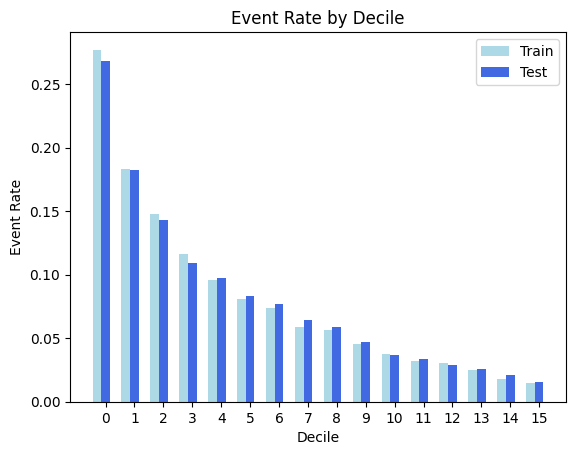

,Metric,Train Value,Test Value
0,KS,0.351785,0.338654
1,AUC,0.737226,0.730094
2,Gini,0.474453,0.460188


In [65]:
metrics, ord_score_train, ord_score_test = calculate_metrics_rl(abt_train_t01, abt_teste_t01, 'Score_1', 'Score_0', 'TARGET', bins=16)
metrics

In [66]:
ord_score_train

,decile,min_score,max_score,event_rate,volume
0,0,0.2788,0.7928,0.277183,9427
1,1,0.7929,0.8468,0.183209,9410
2,2,0.8469,0.8769,0.147588,9452
3,3,0.8770,0.8973,0.116381,9383
4,4,0.8974,0.9126,0.096002,9479
5,5,0.9127,0.9244,0.081064,9400
6,6,0.9245,0.9340,0.074172,9424
7,7,0.9341,0.9422,0.058811,9454
8,8,0.9423,0.9491,0.056094,9395
9,9,0.9492,0.9553,0.045459,9503


In [67]:
ord_score_test

,decile,min_score,max_score,event_rate,volume
0,0,0.2517,0.7924,0.268202,4038
1,1,0.7925,0.8464,0.182538,4043
2,2,0.8465,0.8761,0.143459,4036
3,3,0.8762,0.8966,0.109456,4029
4,4,0.8967,0.9118,0.097363,4057
5,5,0.9119,0.9240,0.083086,4044
6,6,0.9241,0.9337,0.077227,4053
7,7,0.9338,0.9417,0.064371,4008
8,8,0.9418,0.9488,0.058722,4053
9,9,0.9489,0.9550,0.046941,4005


In [61]:
import pickle
with open('../artifacts/modelo_regressao_logistica.pkl', 'wb') as file:
    pickle.dump(model, file)